<a href="https://colab.research.google.com/github/CheshtaG/Customer-Churn/blob/main/02_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
)

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


In [ ]:
df = pd.read_csv("Churn_clean.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [ ]:
print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nTarget distribution:")
print(df["Churn"].value_counts(normalize=True))


Shape: (7043, 20)

Dtypes:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Missing values per column:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod      

In [ ]:
target_col = "Churn"

X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric & categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("\nCategorical columns:", categorical_cols)


Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn rate:", round(y_train.mean() * 100, 2), "%")
print("Test churn rate:", round(y_test.mean() * 100, 2), "%")


Train shape: (5634, 19) Test shape: (1409, 19)
Train churn rate: 26.54 %
Test churn rate: 26.54 %


In [ ]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

clf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [ ]:
clf.fit(X_train, y_train)
print("Model training complete.")


Model training complete.


In [ ]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # for ROC-AUC later

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["No churn", "Churn"]))


Accuracy : 0.8055
Precision: 0.6572
Recall   : 0.5588
F1-score : 0.6040
ROC-AUC  : 0.8419

Classification report:
              precision    recall  f1-score   support

    No churn       0.85      0.89      0.87      1035
       Churn       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[926, 109],
       [165, 209]])

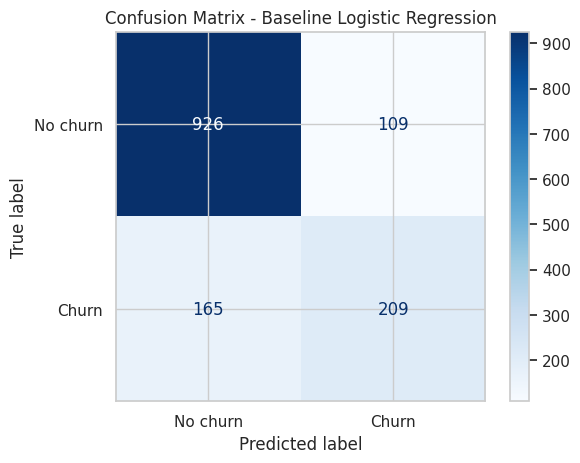

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No churn", "Churn"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()
